In [1]:
# Import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from PIL import Image
from io import BytesIO
import requests
import datetime as dt
import pybaseball as pyb

from constants import *
from config import *
from plotting import plot_headshot, plot_player_bio, plot_team_logo, plot_timeframe, plot_std_stats, plot_percentiles
from utils import get_headshot, get_player_bio, get_team_logo, get_timeframe, get_savant_color, get_filtered_game_logs
from data_processing import calculate_xBA, calculate_xSLG, calculate_xwOBA, process_game_logs, is_barrel, is_sweet_spot


In [1]:
fig, ax = plt.subplots(figsize=(10, 2))
plot_std_stats('683011', FULL_SEASON, FULL_SEASON_END, 2024, ax, 'P')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [3]:
#def get_headshot(player_id, ax: plt.Axes):
    # Construct the image url
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
        f'upload/d_people:generic:headshot:67:current.png/'\
        f'w_640,q_auto:best/v1/people/{player_id}/headshot/silo/current.png'
    # Get the image
    response = requests.get(url)
    # Open the image
    img = Image.open(BytesIO(response.content))
    # Plot the image
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')
    ax.axis('off')

In [328]:
#def player_bio(player_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={player_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Extract player information from the JSON data
    primary_position = data['people'][0]['primaryPosition']['abbreviation']  # Primary position
    player_name = data['people'][0]['fullName'] # Player name
    team = data['people'][0]['currentTeam']['name']  # Current team
    batting_hand = data['people'][0]['batSide']['code']  # Batting hand
    throwing_hand = data['people'][0]['pitchHand']['code']  # Throwing hand
    height = data['people'][0]['height']
    weight = data['people'][0]['weight']
    dob = dt.datetime.strptime(data['people'][0]['birthDate'], '%Y-%m-%d')  # Parse date of birth

    # Calculate the player's age
    today = dt.datetime.today()
    age_days = (today - dob).days
    age_years = age_days // 365
    age_remainder = age_days % 365
    age = f"{age_years}.{age_remainder}"
    
    # Display the player's name, handedness, age, height, and weight on the axis
    ax.text(0.5, .55, f'{primary_position} {player_name}', va='bottom', ha='center', fontsize=50, fontweight='bold')
    ax.text(.5,.275,f'{team}',va='bottom',ha='center',fontsize=35)
    ax.text(0.5, 0, f'B/T: {batting_hand}/{throwing_hand} | {height}/{weight} | Age: {age}', va='bottom', ha='center', fontsize=35)
    # Turn off the axis
    ax.axis('off')

In [ ]:
# def plot_logo(player_id: str, ax: plt.Axes):
    """
    Fetches and displays the logo of a player's current MLB team on a given Matplotlib axis.

    Args:
        player_id (str): The player's MLB ID.
        ax (plt.Axes): Matplotlib axis to display the logo on.
    """
    try:
        # Fetch player data
        url = f"https://statsapi.mlb.com/api/v1/people?personIds={player_id}&hydrate=currentTeam"
        data = requests.get(url).json()

        # Get team abbreviation from player data
        team_link = data['people'][0]['currentTeam']['link']
        team_url = f"https://statsapi.mlb.com{team_link}"
        team_data = requests.get(team_url).json()
        team_abbreviation = team_data['teams'][0]['abbreviation']

        # Get the logo URL from the image dictionary using the team abbreviation
        logo_url = MLB_TEAM_LOGOS.get(team_abbreviation)
        if not logo_url:
            raise ValueError(f"Logo URL not found for team: {team_abbreviation}")

        # Fetch and display the team logo
        response = requests.get(logo_url)
        img = Image.open(BytesIO(response.content))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')
        ax.axis('off')  # Disable the axis for a clean look

    except Exception as e:
        print(f"An error occurred: {e}")

# Call the function
fig, ax = plt.subplots(figsize=(1, 1))
plot_logo(player_id, ax)
plt.show()


In [8]:
# def plot_timeframe(ax, game_type=None, season=None, start_date=None, end_date=None):
    """
    Plots the timeframe label on the given Axes.
    Args:
        ax (plt.Axes): The Axes to plot on.
        game_type (str): Game type ('R', 'P', 'S', or None).
        season (int): The season year.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
    """
    if game_type == "R":
        timeframe_label = f"{season} Regular Season"
    elif game_type == "P":
        timeframe_label = f"{season} Postseason"
    elif game_type == "S":
        timeframe_label = f"{season} Spring Training"
    elif start_date and end_date:
        start = dt.strptime(start_date, "%Y-%m-%d").strftime("%b %d, %Y")
        end = dt.strptime(end_date, "%Y-%m-%d").strftime("%b %d, %Y")
        timeframe_label = f"{start} - {end}"
    else:
        timeframe_label = "Timeframe not specified"

    ax.text(0.5, 0.5, timeframe_label, ha='center', va='center', fontsize=30)
    ax.axis('off')

In [ ]:
plot_headshot('592518', plt.gca())

In [ ]:
plot_player_bio('592518',plt.gca())

In [ ]:
plot_team_logo('592518',plt.gca())

In [ ]:
plot_timeframe('R', ax=plt.gca())

In [ ]:
import concurrent.futures

def fetch_monthly_data(start, end, player_id):
    return pyb.statcast_batter(start, end, player_id=player_id)

months = [("2024-04-01", "2024-04-30"), ("2024-05-01", "2024-05-31"), ("2024-06-01", "2024-06-30"),
            ("2024-07-01", "2024-07-31"), ("2024-08-01", "2024-08-31"), ("2024-09-01", "2024-09-30")]
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda dates: fetch_monthly_data(*dates, "683011"), months))

df = pd.concat(results)
df.info()


Gathering Player Data


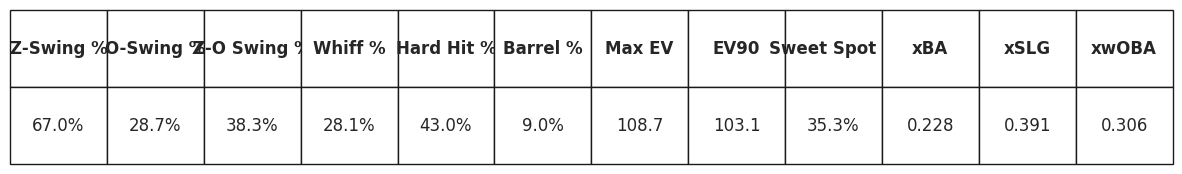

In [5]:
def plot_hitter_adv_stats(player_id: int, start_dt: str, end_dt: str, ax: plt.Axes):
    df = pyb.statcast_batter(start_dt, end_dt, player_id=player_id)  

    df['ball_in_play'] = (df['events'].isin(BIP_EVENTS))

    df['swing'] = df['description'].isin(SWING_CODE)
    df['whiff'] = df['description'].isin(WHIFF_CODE)
    df['in_zone'] = df['zone'] < 10
    df['out_zone'] = df['zone'] > 10
    df['chase'] = df['out_zone'] & df['swing']
    df['hard_hit'] = (df['launch_speed'] >= 95) & (df['ball_in_play'])
    df['ev90'] = df.loc[df['events'].isin(BIP_EVENTS), 'launch_speed'].quantile(0.9)    
    df['max_ev'] = df.loc[df['events'].isin(BIP_EVENTS), 'launch_speed'].max()
    df['barrel'] = df.apply(lambda x: is_barrel(x['launch_speed'], x['launch_angle']), axis=1)
    df['sweet_spot'] = df['launch_angle'].apply(is_sweet_spot) & df['ball_in_play']

    # Calculate stats
    zone_swing_rate = df[df['in_zone']]['swing'].mean()
    out_of_zone_swing_rate = df[df['out_zone']]['swing'].mean()
    whiff_rate = df['whiff'].sum() / df['swing'].sum()  # Whiffs per swing

    # Calculate xBA, xOBP (later), xSLG, and xwOBA
    xBA = calculate_xBA(df)
    #xOBP = calculate_xOBP(df, IBB)
    xSLG = calculate_xSLG(df)
    xwOBA = calculate_xwOBA(df)

    hard_hit_rate = df['hard_hit'].sum() / df['ball_in_play'].sum()  # Hard hits per BIP
    barrel_rate = df[df['ball_in_play']]['barrel'].mean()  
    sweet_spot_rate = df[df['ball_in_play']]['sweet_spot'].mean()

    # Create a DataFrame for the table
    stats = {
        "Z-Swing %": f"{zone_swing_rate * 100:.1f}%",
        "O-Swing %": f"{out_of_zone_swing_rate * 100:.1f}%",
        "Z-O Swing %": f"{100 * (zone_swing_rate - out_of_zone_swing_rate):.1f}%",
        "Whiff %": f"{whiff_rate * 100:.1f}%",
        "Hard Hit %": f"{hard_hit_rate * 100:.1f}%",
        "Barrel %": f"{barrel_rate * 100:.1f}%",
        "Max EV": f"{df['max_ev'].values[0]:.1f}",
        "EV90" : f"{df['ev90'].values[0]:.1f}",
        "Sweet Spot %": f"{sweet_spot_rate * 100:.1f}%",
        "xBA": f"{xBA:.3f}",
        "xSLG": f"{xSLG:.3f}",
        "xwOBA": f"{xwOBA:.3f}"#,
    }
    df_stats = pd.DataFrame([stats.values()], columns=stats.keys())

    # Create the table
    table = ax.table(cellText=df_stats.values, colLabels=df_stats.columns, 
                    cellLoc='center',bbox=[0.0, 0.0, 1.0, 1.0]
    )
    table.set_fontsize(12)
    table.auto_set_font_size(False)

    # Make column headers bold
    for i, col in table.get_celld().items():
        if i[0] == 0:
            col.set_text_props(weight='bold')

    ax.axis('off')

# Example usage
fig, ax = plt.subplots(figsize=(15, 2))
plot_hitter_adv_stats(683011, SEASON_DATES[2023]['REG_START'], SEASON_DATES[2023]['REG_END'], ax)
plt.show()

In [20]:
from scipy.stats import percentileofscore

def plot_percentiles(player_stats, season, ax):

    metrics = list(player_stats.keys())

    # Define metrics where lower is better
    lower_is_better = ['Whiff%', 'O-Swing%']
    
    # Load league stats
    league_stats = pd.read_csv(f'data/clean{season}.csv')

    percentiles = {}
    for metric in metrics:
        raw_percentile = percentileofscore(league_stats[metric], player_stats[metric], kind='mean')
        percentiles[metric] = 100 - raw_percentile if metric in lower_is_better else raw_percentile

    y_pos = np.arange(len(metrics))


    # Plot bars and circles
    for i, metric in enumerate(metrics):
        pct = percentiles[metric]
        value = player_stats[metric]
        color = get_savant_color(pct)
        bar_height = 0.85

        # Background gray bar
        ax.barh(i, 100, color=PERCENTILE_COLORS['gray'], height = bar_height/4 , zorder=1)
        
        # Colored percentile bar
        ax.barh(i, pct, color=color, height=bar_height, zorder=2)
        
        # Circle
        ellipse = patches.Ellipse((pct, i), width= bar_height * 6.8,  # not sure why this works
                                  height = bar_height, 
                                facecolor=color, edgecolor = 'white', 
                                linewidth=3, zorder=3)
        ax.add_patch(ellipse)
        
        # Percentile text
        font_size = 22 if pct == 100 else 27  # Adjust font size if percentile is 100
        ax.text(pct, i, f'{int(pct)}', 
                ha='center', va='center_baseline',
                color='white', 
                fontsize= font_size,
                fontweight='bold',
                zorder=4)
        
        # Value text
        value_text = (f'{value:.3f}'[1:] if metric in ['xBA', 'xSLG', 'xwOBA'] and value < 1
                    else f'{value:.3f}' if metric in ['xBA', 'xSLG', 'xwOBA']
                    else f'{value:.1f}' if metric == 'EV90'
                    else f'{value:.1f}%')
        ax.text(103, i, value_text,
                ha='left', va='center',
                fontsize=25)
    
    # Styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels(metrics, fontsize=25, ha='right')
    ax.set_xlim(-10, 110)
    for label in ax.get_yticklabels():
        label.set_x(.08)  # Adjust the value as needed
    ax.set_xlabel("")
    ax.grid(False)
    ax.set_xticks([])  # Remove x-axis numbers
    ax.spines['left'].set_visible(False)   # Remove left spine
    ax.spines['right'].set_visible(False)  # Remove right spine
    ax.spines['top'].set_visible(False)    # Remove top spine
    ax.spines['bottom'].set_visible(False) # Remove bottom spine

    return ax

In [2]:

player_stats = {
    'Z-O Swing%': 39.1,
    'O-Swing%': 28.7,
    'Z-Swing%': 67.2,
    'Whiff%': 28.2,
    'Sweet Spot%': 29.2,
    'Hard Hit%': 43,
    'Barrel%': 17.6,
    'EV90': 105,
    'xSLG': 0.494,
    'xBA': 0.284,
    'xwOBA': 0.374
}

Gathering Player Data


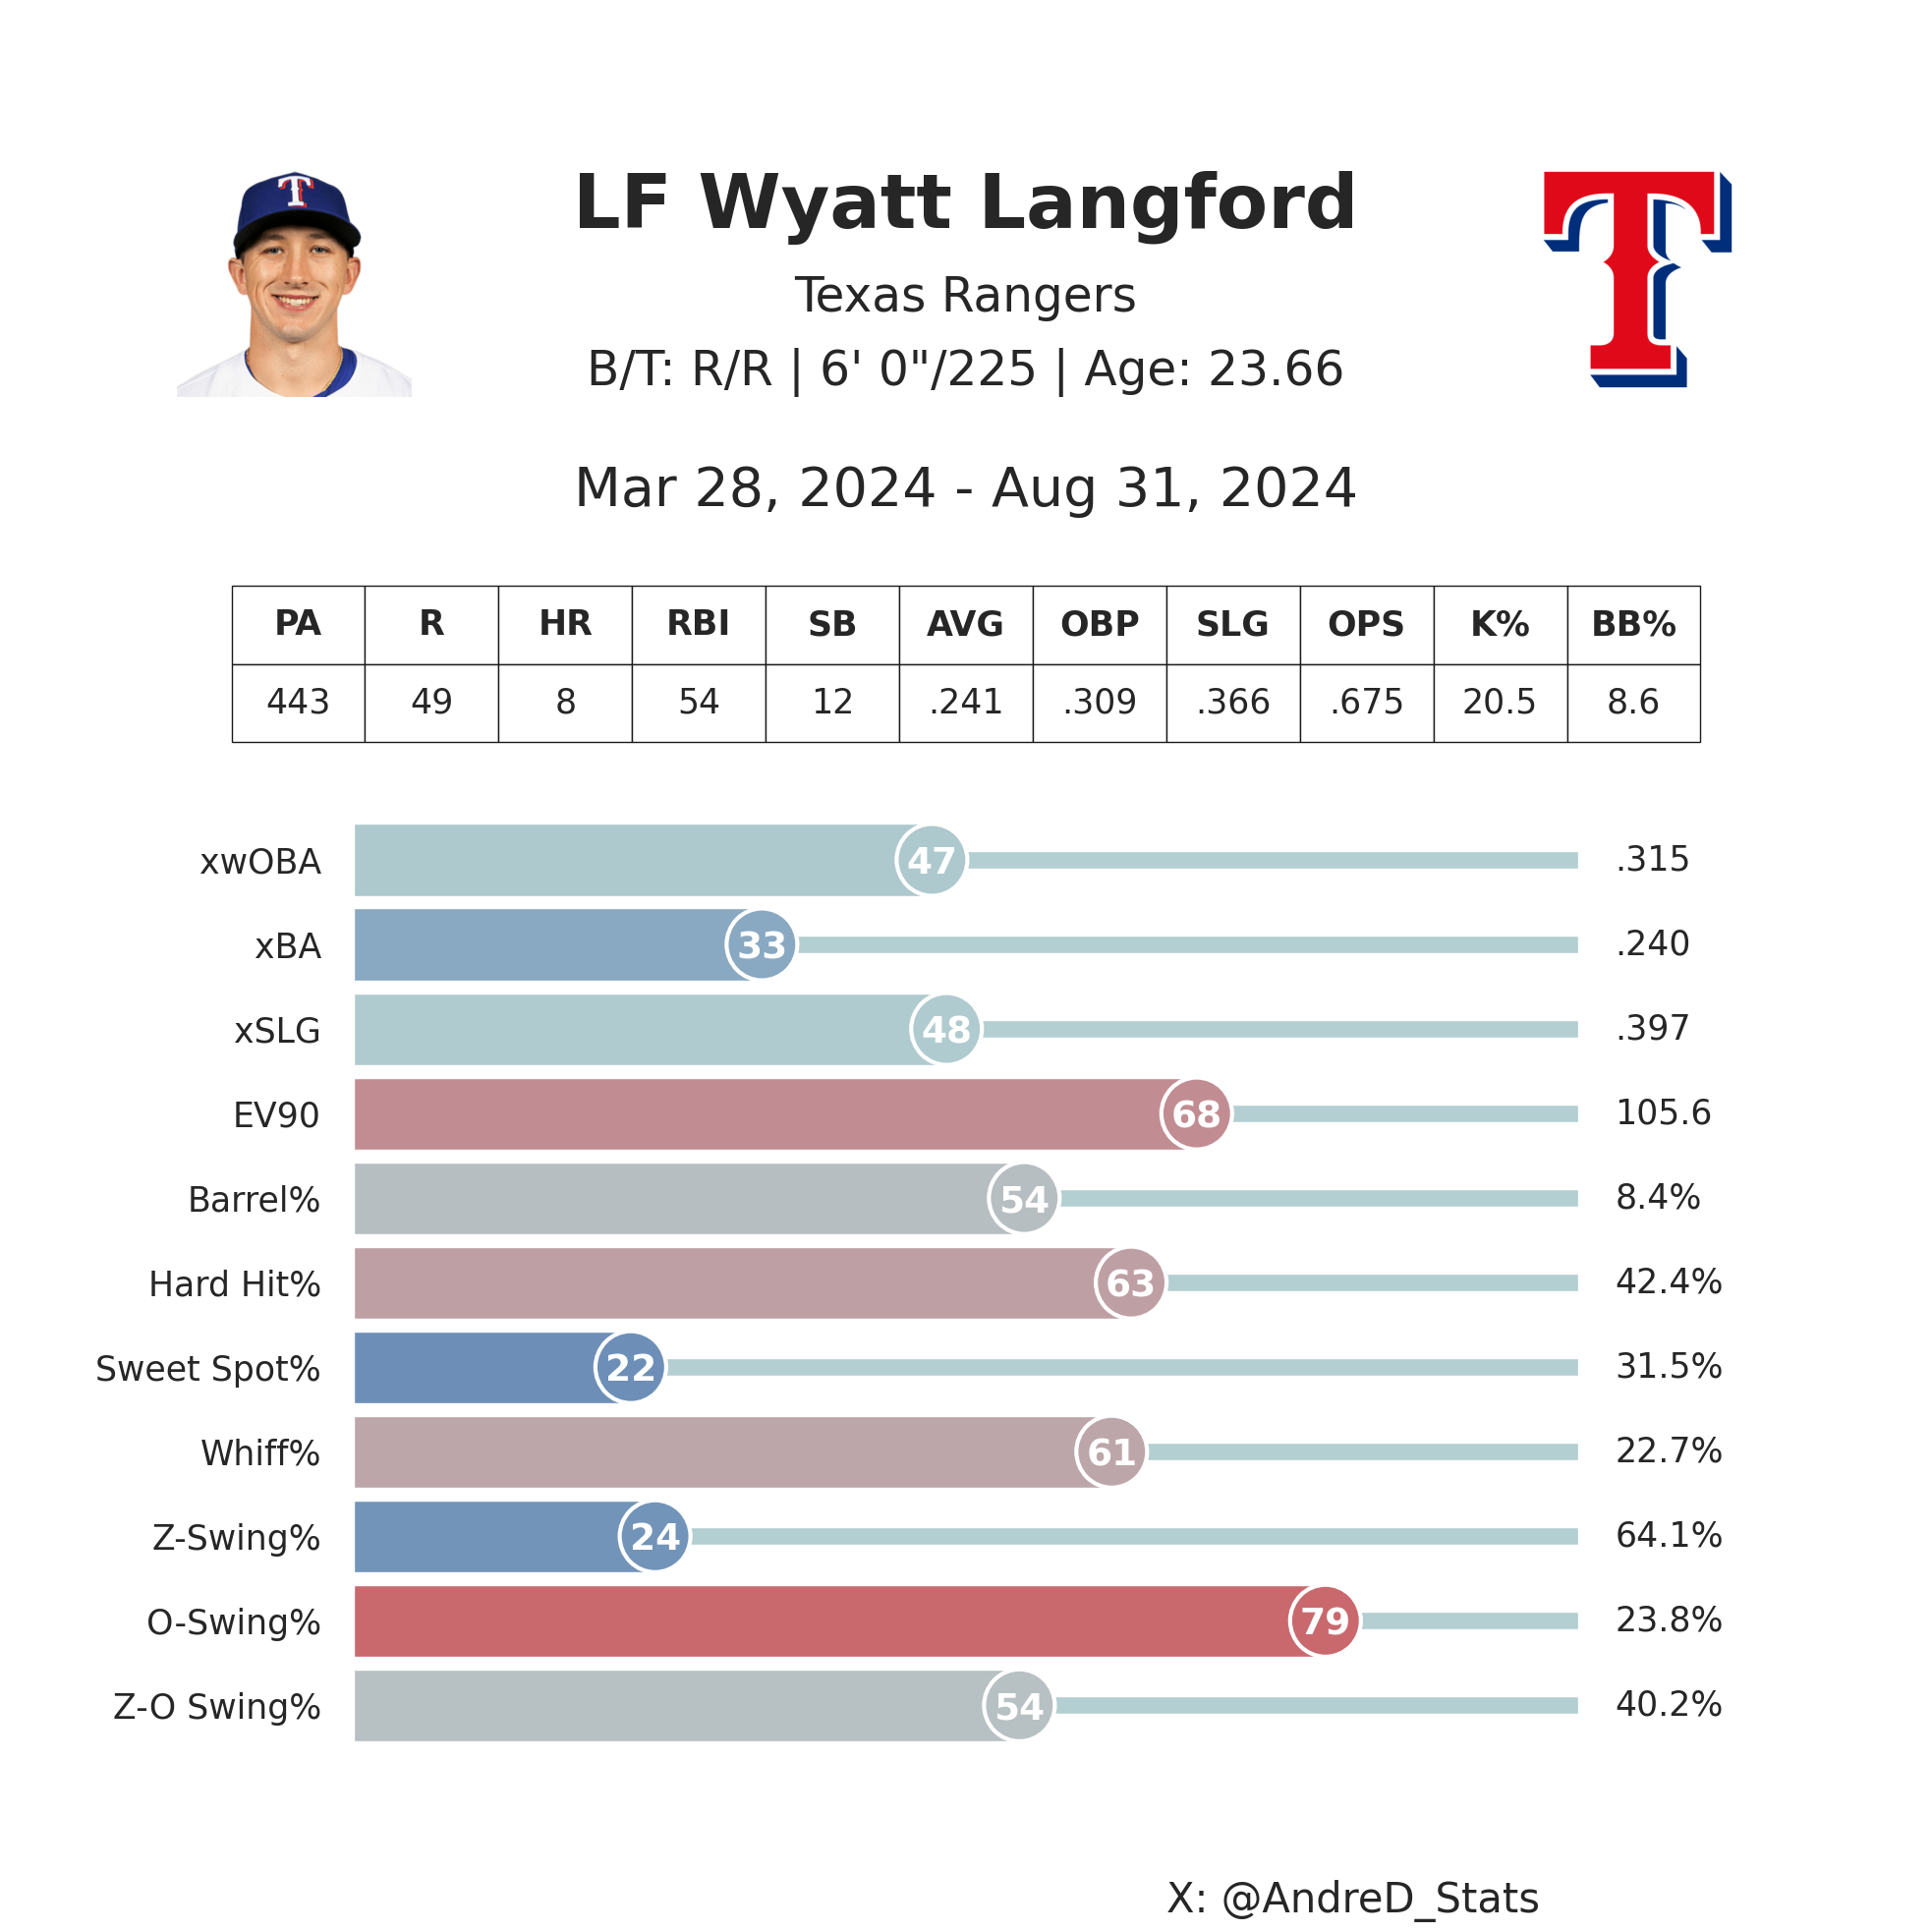

In [6]:
def make_batter_card(player_id, game_type=None, start_date= None, end_date=None, season=2024):
    # Create a figure of size 20x20
    fig = plt.figure(figsize=(20, 20))
    
    # Create a gridspec layout with 8 columns and 6 rows
    gs = gridspec.GridSpec(8, 8,
                        height_ratios=[3,6,3,4,8,8,8,2],
                        width_ratios=[2,16,16,16,16,16,16,2])

    # Define the position of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1, 0:3])  # Top-left for headshot
    ax_bio = fig.add_subplot(gs[1, 1:7])  # Space for bio
    ax_logo = fig.add_subplot(gs[1, 5:9])  # Top-right for team logo
    ax_timeframe = fig.add_subplot(gs[2, 1:7])  # Timeframe 
    ax_player_stats = fig.add_subplot(gs[3, 1:7])  # Player stats
    ax_savant = fig.add_subplot(gs[4:7, 1:7])  # Savant plot
    ax_text = fig.add_subplot(gs[7, 5])  # Text
    
    # Hide the header, footer, and side borders for now
    ax_footer = fig.add_subplot(gs[-1, 1:7])
    ax_header = fig.add_subplot(gs[0, 1:7])
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    # Hide the axes for the borders
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')
    
    # Plot the headshot, bio, logo (static)
    plot_headshot(player_id, ax_headshot)
    plot_player_bio(player_id, ax_bio)
    plot_team_logo(player_id, ax_logo)

    # Plot the timeframe label based on the game type
    plot_timeframe(game_type=game_type, start_date=start_date, end_date=end_date, season=season, ax=ax_timeframe)    
    
    # Plot player standard stats 
    plot_std_stats(player_id, start_dt=start_date, end_dt=end_date, 
                   season=season, ax = ax_player_stats, game_type=game_type)    
    
    # Plot the Savant plot
    plot_percentiles(player_id=player_id, start_dt=start_date, end_dt=end_date, season=season, ax=ax_savant)
    ax_savant.set_anchor('E')

    # Plot my X handle on the bottom right
    ax_text.text(0, 0, "X: @AndreD_Stats", ha='center', va='center', fontsize=30)
    ax_text.axis('off')

    # Ensure the layout is adjusted properly
    plt.tight_layout()
    # Show the figure
    plt.show()

# Plot the image on the dashboard
make_batter_card(694671,start_date='2024-03-28', end_date='2024-08-31', 
                 game_type="R", season=2024)

In [13]:
df = pyb.statcast_batter('2024-03-28', '2024-03-31', player_id=694671)
df

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,CH,2024-03-31,81.7,2.35,5.80,"Langford, Wyatt",694671,696136,triple,hit_into_play,...,3,2,NaN,1.0,6,1,2.80,0.98,-0.98,47.4
1,CH,2024-03-31,81.8,2.25,5.82,"Langford, Wyatt",694671,696136,NaN,ball,...,3,2,NaN,1.0,6,1,2.60,0.63,-0.63,47.0
2,FF,2024-03-31,94.0,2.18,5.93,"Langford, Wyatt",694671,696136,strikeout,foul_tip,...,2,1,NaN,1.0,6,1,0.92,0.33,-0.33,54.9
3,CH,2024-03-31,82.5,2.22,5.84,"Langford, Wyatt",694671,696136,NaN,swinging_strike,...,2,1,NaN,1.0,6,1,2.71,0.76,-0.76,49.2
4,CH,2024-03-31,82.4,2.42,5.81,"Langford, Wyatt",694671,696136,NaN,swinging_strike,...,2,1,NaN,1.0,6,1,2.52,0.96,-0.96,49.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,ST,2024-03-28,79.5,-1.50,5.78,"Langford, Wyatt",694671,622075,NaN,called_strike,...,1,2,NaN,NaN,2,2,3.86,-1.53,-1.53,37.1
64,SI,2024-03-28,93.4,-1.30,5.90,"Langford, Wyatt",694671,593576,NaN,ball,...,1,3,NaN,NaN,3,2,1.57,1.47,1.47,41.4
65,FS,2024-03-28,82.7,-1.35,5.95,"Langford, Wyatt",694671,593576,NaN,ball,...,1,3,NaN,NaN,3,2,3.36,0.91,0.91,39.8
66,SI,2024-03-28,95.6,-1.34,5.68,"Langford, Wyatt",694671,622075,NaN,called_strike,...,1,2,NaN,NaN,2,2,2.00,1.58,1.58,40.2


In [14]:
df.columns.to_list()

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'fielder_2',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'w